In [5]:
#env used: bbVV

from typing import List
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
import os

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 20})

In [6]:
MAIN_DIR = "../"

plot_dir = f"{MAIN_DIR}/plots/bias_test/01Feb24"
_ = os.system(f"mkdir -p {plot_dir}")

In [7]:
biases = ["0","1","0p2","0p6","3","5"] #I don't like "." in path name, so I used "p" to replace it
# biases = ["3"]
bias_dict = {
    "0":0,
    "1":1,
    "0p2":0.2,
    "0p6":0.6,
    "3":3,
    "5":5
} #then we need to transfer that string to number
r_bounds = [-40, 40]
r_dict = {}
for bias in biases:
    file = uproot.concatenate(
        f"/home/pku/zhaoyz/Higgs/boostedHWW/combine/bias_test/cards/scale{bias}/higgsCombinebias{bias_dict[bias]}.FitDiagnostics.mH125.*.root"
    )
    r = np.array(file.limit)[::4] #best fit signal strength r
    neg_lim = np.array(file.limit)[1::4] #the r value with negative error
    pos_lim = np.array(file.limit)[2::4] #the r value with positive error
    r_negerr = r - neg_lim #the error with respect to the r
    r_poserr = pos_lim - r
    reldiff = r - bias_dict[bias] #difference between best fit r and injected r
    reldiff[reldiff < 0] = (reldiff / r_poserr)[reldiff < 0]# if best fitted r < injected r, we should use r_poserr as error
    reldiff[reldiff > 0] = (reldiff / r_negerr)[reldiff > 0]
    r_dict[bias] = {
        "r": r,
        "reldiff": reldiff,
        "neg_lim": neg_lim,
        "pos_lim": pos_lim,
    }

In [8]:
r_dict["3"]

{'r': array([ 2.74105001,  4.53676424,  1.80997152,  3.76371701,  3.92075751,
         3.22828973,  0.63526905,  2.81458993,  1.93001583,  2.11601785,
         4.6564998 ,  2.93030961,  5.83881359,  3.29330485,  1.48748612,
         3.41890479,  3.77857931,  2.3948481 ,  1.46126362,  1.66255157,
         3.13402114,  1.34777213,  3.70570776,  3.04358924,  2.66160352,
         1.30838421,  4.65289608,  0.64168435,  3.57175737,  2.92372139,
         6.19477623,  3.99790854,  3.16686417,  6.7175337 ,  2.08963362,
         6.47340652,  4.05209115,  1.38696555,  2.97982326,  1.37141249,
         0.59430997,  4.93332426,  4.15590482,  2.38342743,  2.49468746,
         4.42186013,  2.93916471,  4.92941965,  1.36274321,  1.21648311,
         1.48231752,  2.14791166,  1.80912996,  3.03082863,  3.85612566,
         6.58886364,  1.2501911 ,  5.17426043,  3.62458774,  3.20893308,
         3.35589293,  4.89051534,  4.92142806,  3.32876125,  1.01220145,
         5.5099691 ,  1.99996281,  4.31464845,

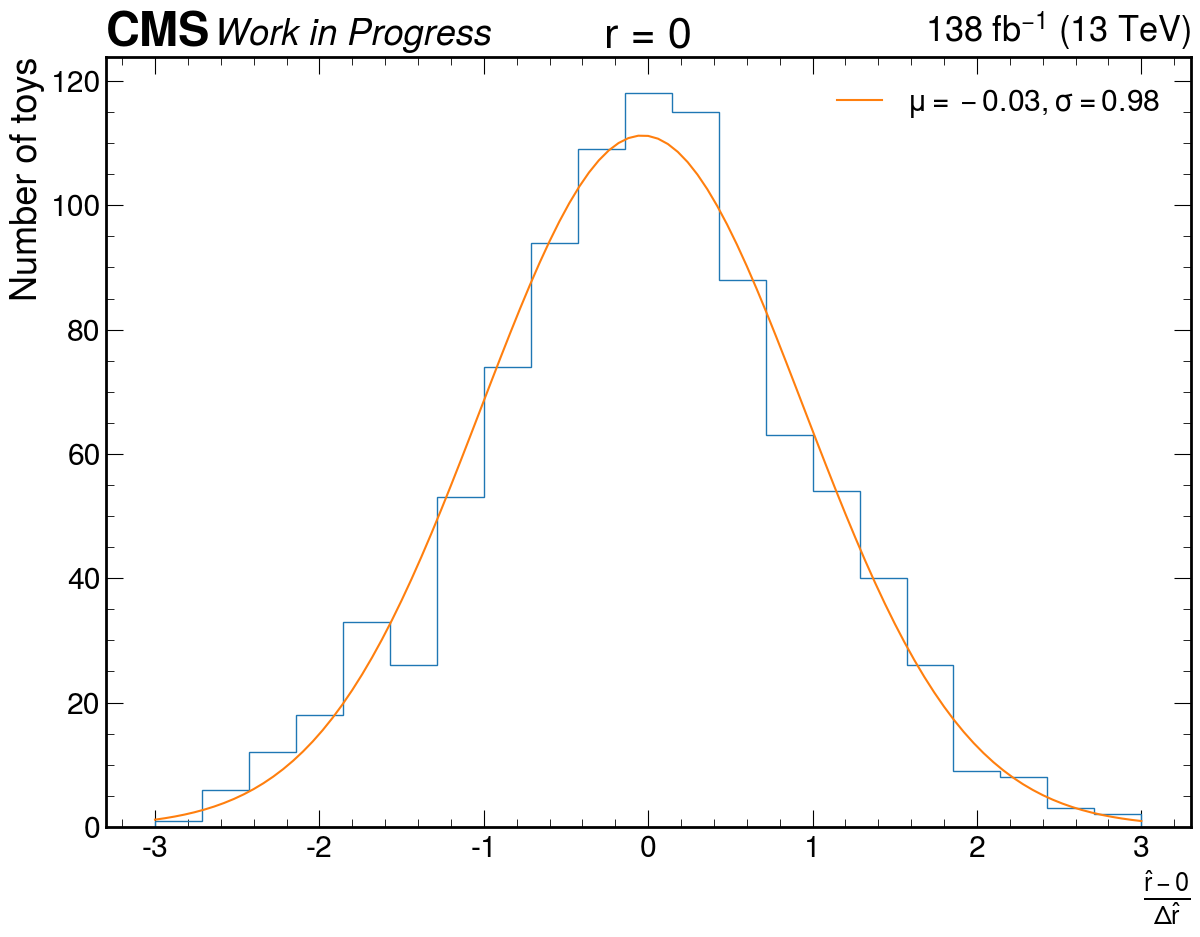

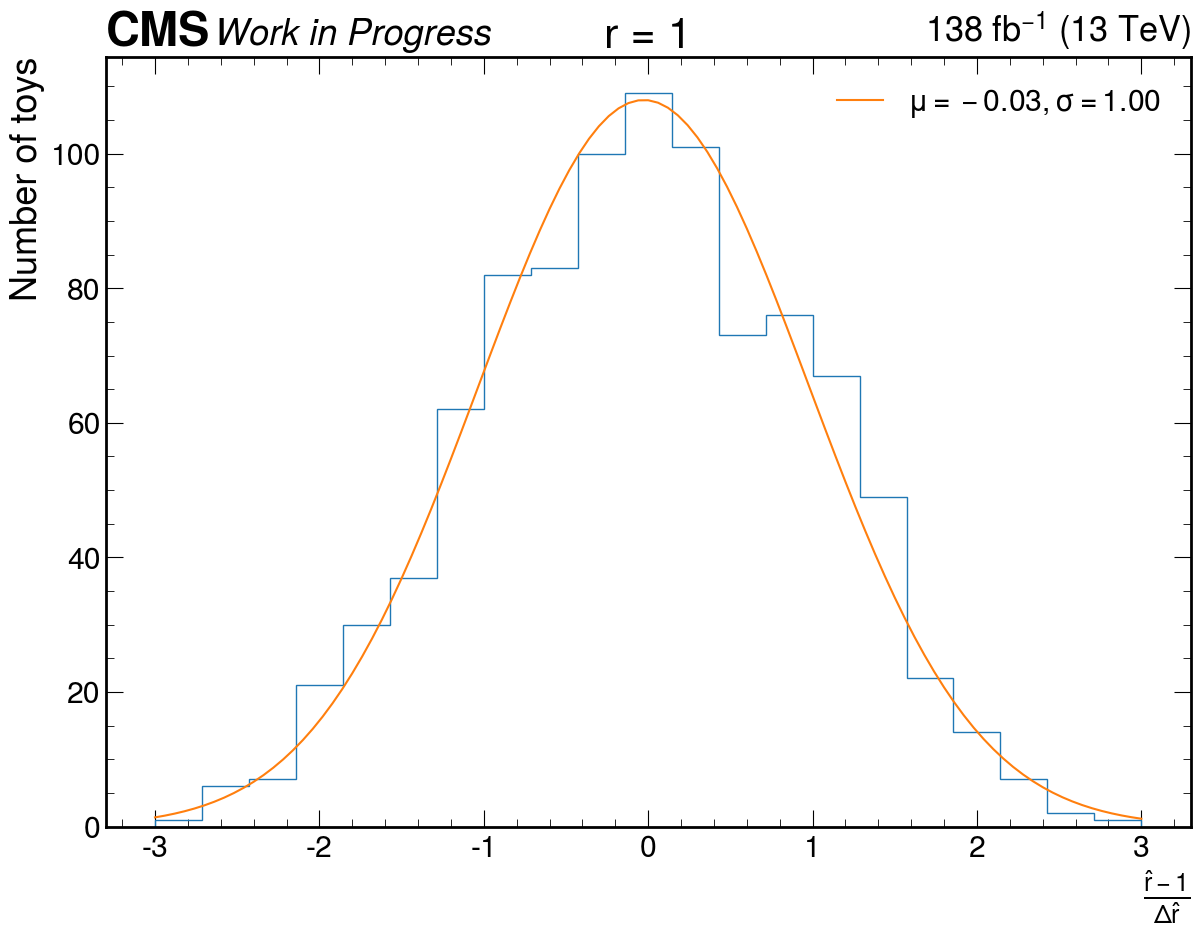

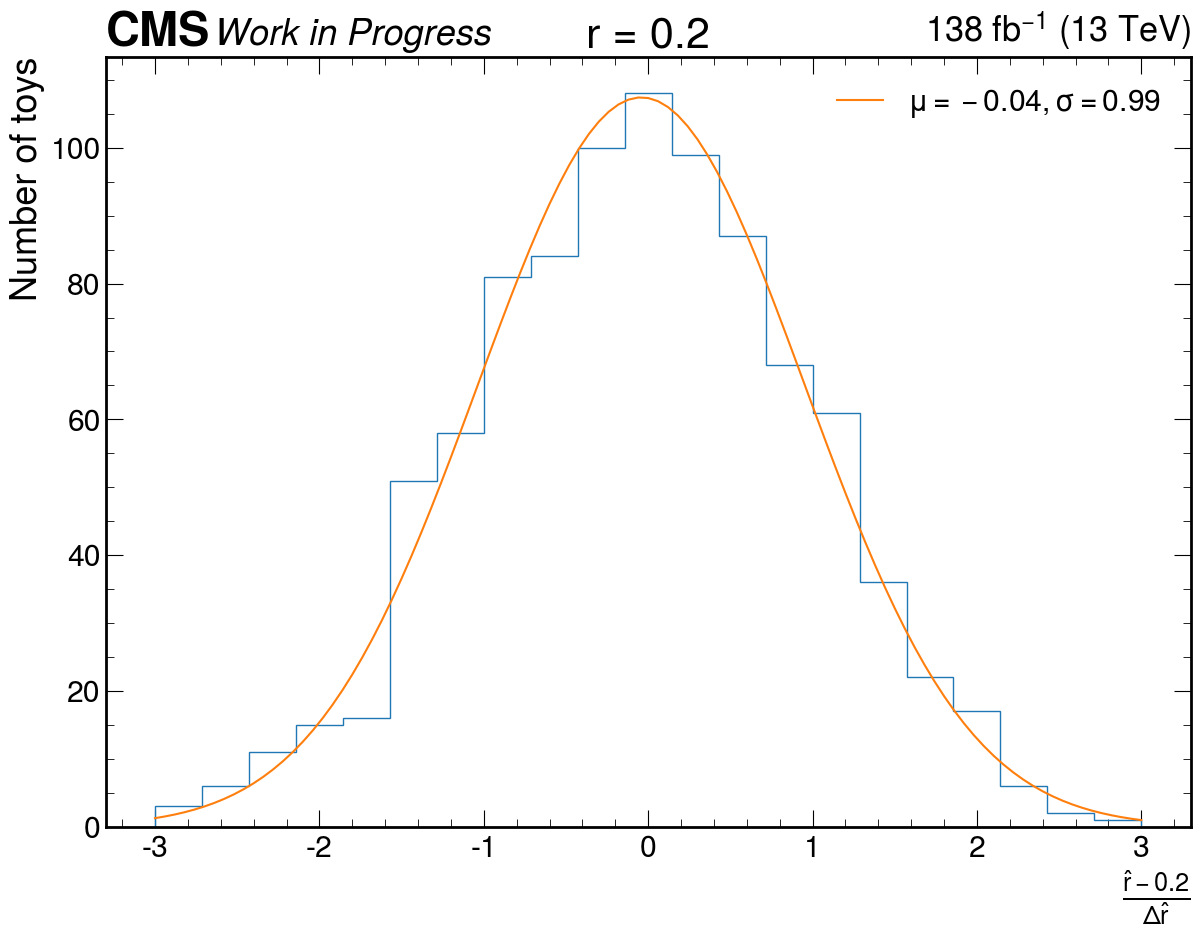

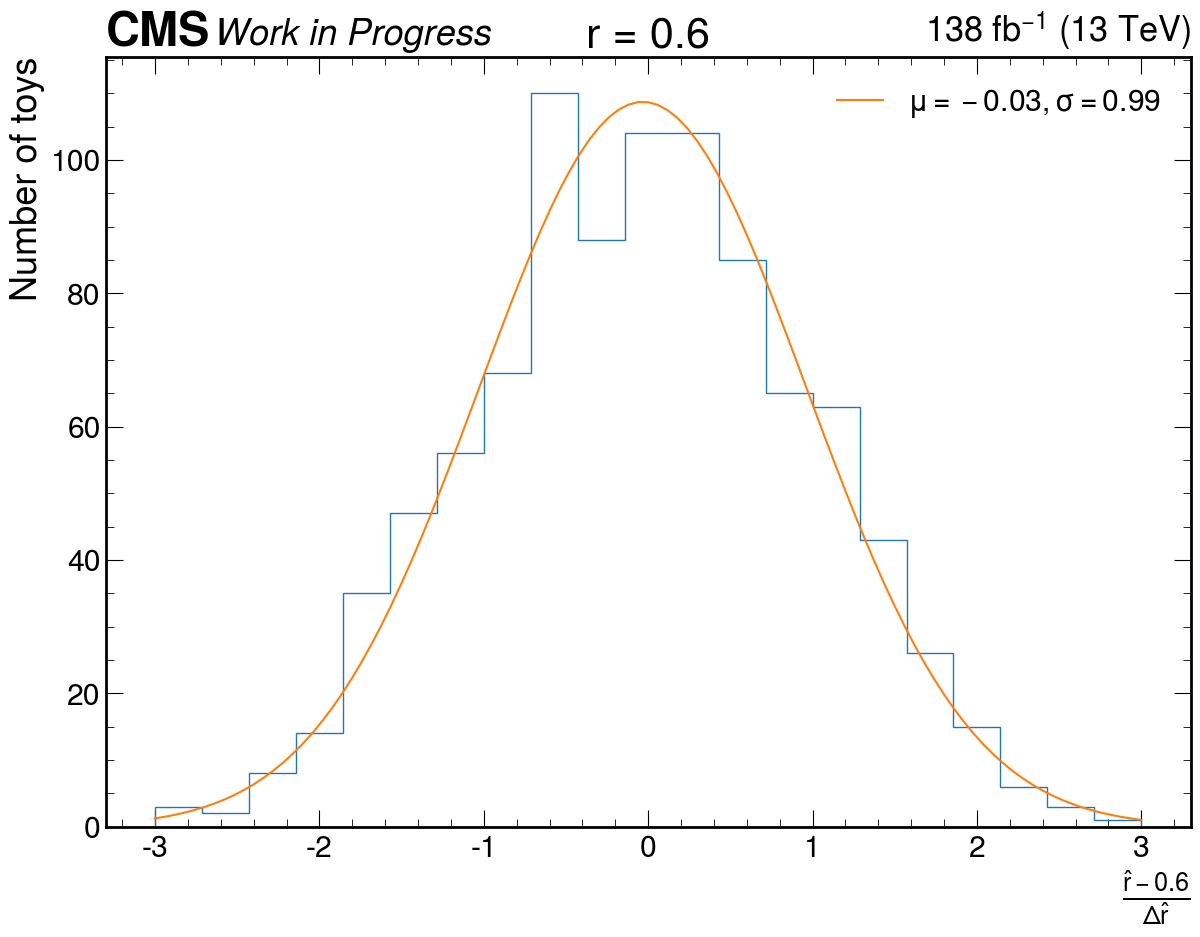

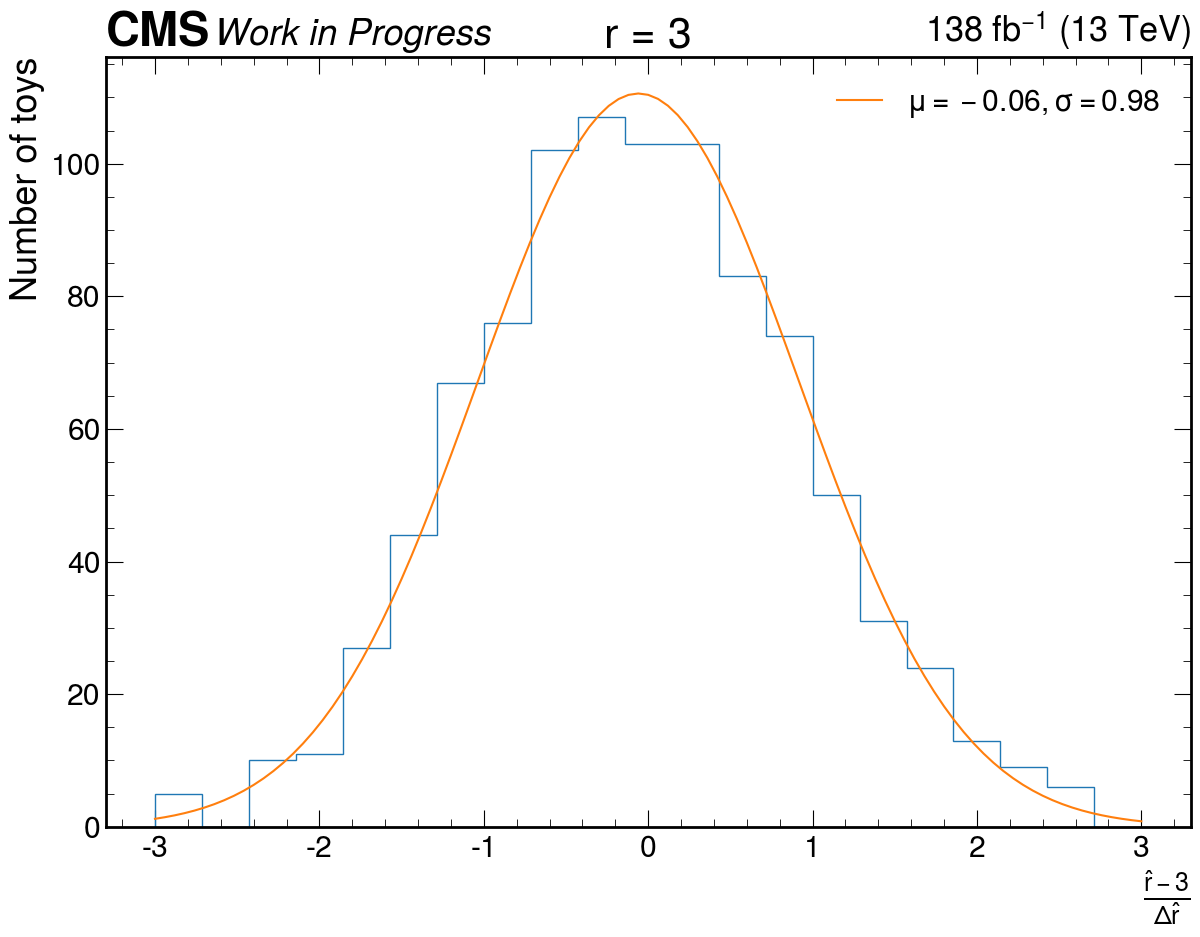

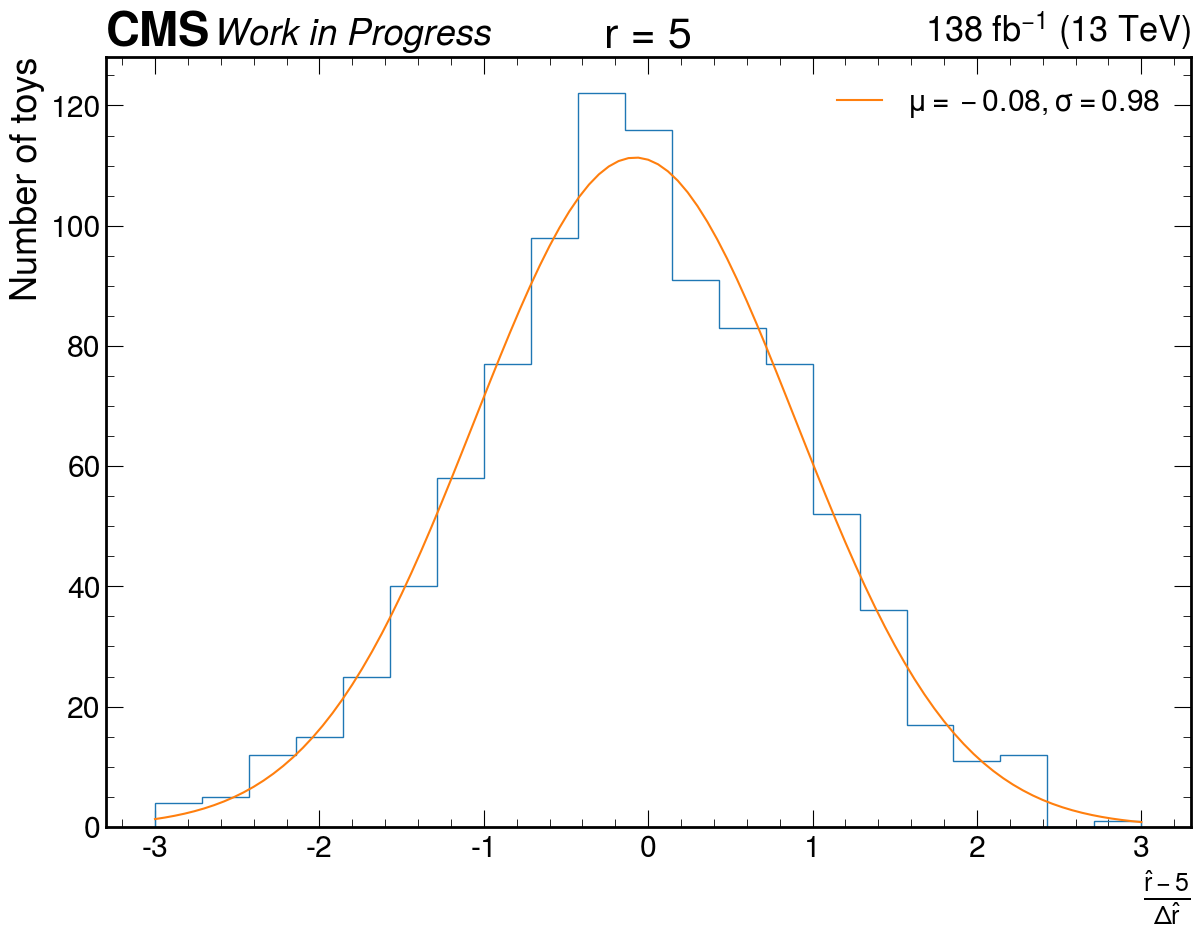

In [9]:
#plot the bias plots
from scipy import stats
xrange = 3
bins = 21
x = np.linspace(-xrange, xrange, 101)
# fig, ax = plt.subplots(len(biases), 1, figsize=(12, 40))
for i, bias in enumerate(biases):
    hep.style.use("CMS")
    plt.figure(figsize=(14, 10))
    ax = plt.gca()
    r_lims_bounds = (
        (r_dict[bias]["reldiff"] < 0)
        * (np.isclose(r_dict[bias]["pos_lim"], r_bounds[1]))
    ) + (
        (r_dict[bias]["reldiff"] > 0)
        * (np.isclose(r_dict[bias]["neg_lim"], r_bounds[0]))
    )
    r_lims_same = r_dict[bias]["pos_lim"] == r_dict[bias]["neg_lim"]
    fit_fail = r_lims_bounds + r_lims_same
    r = r_dict[bias]["r"][~fit_fail]
    reldiff = r_dict[bias]["reldiff"][~fit_fail]
    reldiff = reldiff[(reldiff > -xrange) * (reldiff < xrange)]
    mu, sigma = np.mean(reldiff), np.std(reldiff)
    ax.hist(reldiff, np.linspace(-xrange, xrange, bins + 1), histtype="step")
    ax.plot(
        x,
        # scale by bin width
        stats.norm.pdf(x, loc=mu, scale=sigma) * len(r) * (2 * xrange / bins),
        label=rf"$\mu = {mu:.2f}, \sigma = {sigma:.2f}$",
    )
    ax.set_xlabel(rf"$\frac{{\hat{{r}} - {bias_dict[bias]}}}{{\Delta \hat r}}$")
    ax.set_ylabel("Number of toys")
    ax.set_title(f"r = {bias_dict[bias]}")
    ax.legend()
    hep.cms.label(
        "Work in Progress",
        ax=ax,
        data=True,
        lumi=138,
        year=None,
    )
    plt.savefig(f"{plot_dir}/bias_test_plots_{bias}.pdf", bbox_inches="tight")
    plt.show()